In [2]:
%matplotlib inline
from collections import Counter
import cPickle as pickle
import datetime
# import holidays
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# -- load data --
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')
d_base = pd.read_csv("./data/example_orders.csv", parse_dates = [3], date_parser = dateparse)
d_base['cancelled'] = map(lambda x: 1 if x > 0 else 0, d_base.cancelled_reason)

# -- apply date shift --
corrupted_ind = d_base[d_base['day'] == datetime.datetime(2013, 12, 7)].index[0]
d_base.ix[corrupted_ind:, 'day'] = d_base.ix[corrupted_ind:, 'day'] - pd.Timedelta(days=1) 
d_base = d_base.set_index(d_base['day']).drop('day', 1)

# -- filter data --
pd.options.mode.chained_assignment = None  # default='warn'
# calculate number of fulfilled orders for each user on each day
d_trans = d_base
grp = d_trans[['user_id', 'cancelled']].groupby([d_trans.index, d_trans.user_id]).cancelled
d_trans['difference'] = grp.transform('count') - grp.transform('sum')
# If a user has only cancelled orders, take only 1
# otherwise take all fulfilled orders
filtering = lambda x: x.iloc[[0]] if x.difference[0] == 0 else x[x.cancelled == 0]
d_trans = d_trans.groupby([d_trans.user_id]).apply(filtering)
d_trans = d_trans.drop(['user_id', 'difference'], 1)
d_trans = d_trans.reset_index(level = 0).sort_index()

# -- make timeseries by day --
d_group = pd.DataFrame({'orders':d_trans.groupby(d_trans.index).size()})
# remove last day as an outlier
d_group = d_group.ix[:-1, ]

# -- additional features --
# uk_holidays = holidays.UK()
# d_group['weekday'] = map(lambda x: 1 if x.weekday() < 5 else 0, d_group.index)
# d_group['holiday'] = map(lambda x: 1 if x in uk_holidays else 0, d_group.index)

print d_group.head(n=10)
print d_group.tail(n=10)
print d_group.max()
print d_group.min()

            orders
day               
2013-01-01     144
2013-01-02     159
2013-01-03     129
2013-01-04     163
2013-01-05     203
2013-01-06     169
2013-01-07     130
2013-01-08     176
2013-01-09     165
2013-01-10     187
            orders
day               
2014-11-19     967
2014-11-20    1049
2014-11-21     968
2014-11-22    1058
2014-11-23     860
2014-11-24     842
2014-11-25     838
2014-11-26     839
2014-11-27     829
2014-11-28     803
orders    1161
dtype: int64
orders    101
dtype: int64


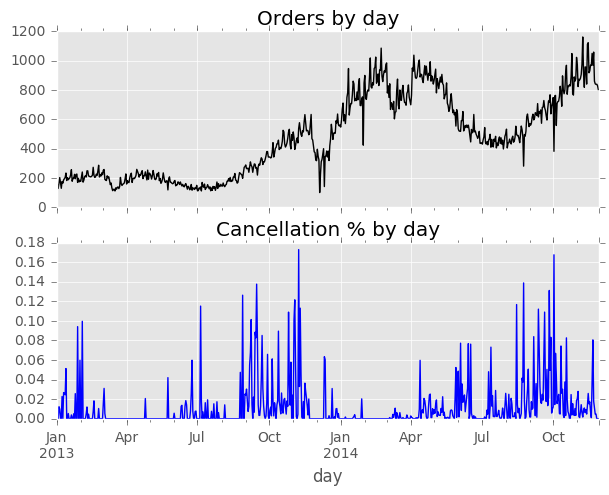

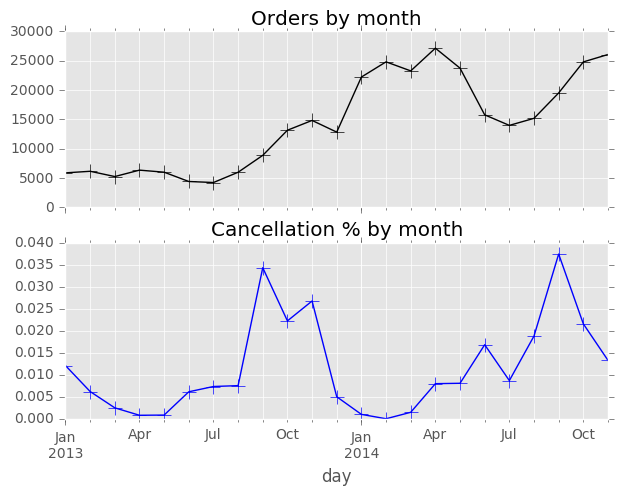

In [3]:
# -- visualize data --
plt.style.use('ggplot')

# orders and cancellations % by day
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (7, 5))
d_group['orders'].plot(ax = ax1, style = 'k', title = "Orders by day")
perc_cancelled_by_month = d_trans.groupby(d_trans.index)['cancelled'].agg({'cancelled %':np.mean})
perc_cancelled_by_month.plot(ax = ax2, style = 'b', title = "Cancellation % by day", legend = False)

# orders and cancellations % by month
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (7, 5))
total_by_month = d_group.groupby(pd.TimeGrouper("M")).orders.agg('sum')
total_by_month.plot(ax = ax1, style = 'k', marker='+', ms=10, title = "Orders by month")
perc_cancelled_by_month = d_trans.groupby(pd.TimeGrouper("M"))['cancelled'].agg({'cancelled %':np.mean})
perc_cancelled_by_month.plot(ax = ax2, style = 'b', marker='+', ms=10, title = "Cancellation % by month", legend = False)
ax1.grid(True, which='both')
ax2.grid(True, which='both')

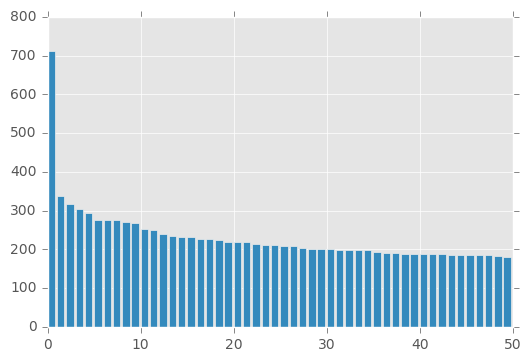

In [4]:
# -- visualize biggest users --
counts = [x[1] for x in Counter(d_trans['user_id']).most_common()][0:50]
fig = plt.figure()
ax = plt.subplot(111)
ax.bar(range(len(counts)), counts)
plt.show()

# Note: possible test/corrupted data present for the most common user?

Epoch 1/100
1s - loss: 0.0878
Epoch 2/100
0s - loss: 0.0359
Epoch 3/100
0s - loss: 0.0145
Epoch 4/100
0s - loss: 0.0093
Epoch 5/100
0s - loss: 0.0087
Epoch 6/100
0s - loss: 0.0080
Epoch 7/100
0s - loss: 0.0078
Epoch 8/100
0s - loss: 0.0075
Epoch 9/100
0s - loss: 0.0071
Epoch 10/100
0s - loss: 0.0070
Epoch 11/100
0s - loss: 0.0068
Epoch 12/100
0s - loss: 0.0062
Epoch 13/100
0s - loss: 0.0068
Epoch 14/100
0s - loss: 0.0061
Epoch 15/100
0s - loss: 0.0065
Epoch 16/100
0s - loss: 0.0064
Epoch 17/100
0s - loss: 0.0061
Epoch 18/100
0s - loss: 0.0060
Epoch 19/100
0s - loss: 0.0062
Epoch 20/100
0s - loss: 0.0060
Epoch 21/100
0s - loss: 0.0059
Epoch 22/100
0s - loss: 0.0057
Epoch 23/100
0s - loss: 0.0056
Epoch 24/100
0s - loss: 0.0055
Epoch 25/100
0s - loss: 0.0055
Epoch 26/100
0s - loss: 0.0050
Epoch 27/100
0s - loss: 0.0053
Epoch 28/100
0s - loss: 0.0052
Epoch 29/100
0s - loss: 0.0050
Epoch 30/100
0s - loss: 0.0050
Epoch 31/100
0s - loss: 0.0051
Epoch 32/100
0s - loss: 0.0049
Epoch 33/100
0s -

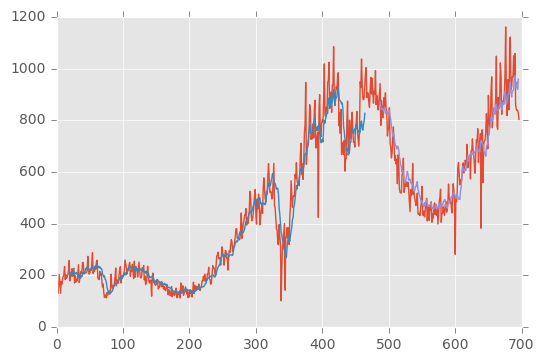

In [5]:
# -- Single layer LSTM RNN network --
def create_dataset(dataset, look_back=1, look_forward=1):
    ''' 
    Convert an array of values into a dataset 
    matrix with @look_back number of steps as features,
    and @look_forward target values per sample.
    '''
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back - look_forward):
        offset = i + look_back
        data_x.append(dataset[i:offset, 0])
        data_y.append(dataset[offset:(offset + look_forward), 0])
    return np.array(data_x), np.array(data_y)

# fix random seed for reproducibility
np.random.seed(42)

# normalize the dataset, LSTM is scale sensitive
dataset = d_group.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
# reshape into training matrix of time series slices
look_back = 21
look_forward = 7
train_x, train_y = create_dataset(train, look_back, look_forward)
test_x, test_y = create_dataset(test, look_back, look_forward)

# Reshape input to be [samples, time steps, features]
# In our case, each time step has @look_back number of features
# Note: we can also shape it as train_x[0], train_x[1], 1 (or > 1 if more actual
# features are used (like holdays, weekends, seasons etc.))
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(input_dim=look_back, output_dim=20))
model.add(Dropout(0.032231449370770484))
model.add(Dense(input_dim=10, output_dim=look_forward))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, nb_epoch=100, batch_size=16, verbose=2, 
          callbacks=[EarlyStopping(monitor='loss', patience=5)])

# make predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform(train_y)
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform(test_y)

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_y, train_predict))
print('Train score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_y, test_predict))
print('Test score: %.2f RMSE' % (test_score))

# average all train predictions for a given day
train_predict_plot = np.zeros((train_predict.shape[0], 
                               train_predict.shape[0] + train_predict.shape[1] - 1))
for i in xrange(len(train_predict)):
    train_predict_plot[i, i:(i + train_predict.shape[1])] = train_predict[i]
totals = train_predict_plot.sum(0)
normalizer = (train_predict_plot != 0).sum(0)
train_predict_plot = np.expand_dims(totals / normalizer, axis=1)
# average all test predictions for a given day 
test_predict_plot = np.zeros((test_predict.shape[0], 
                              test_predict.shape[0] + test_predict.shape[1] - 1))
for i in xrange(len(test_predict)):
    test_predict_plot[i, i:(i + test_predict.shape[1])] = test_predict[i]
totals = test_predict_plot.sum(0)
normalizer = (test_predict_plot != 0).sum(0)
test_predict_plot = np.expand_dims(totals / normalizer, axis=1)

# shift train predictions for plotting
train_predict_plot_avg = np.empty_like(dataset)
train_predict_plot_avg[:, :] = np.nan
train_predict_plot_avg[look_back:len(train_predict_plot) + 
                       look_back, :] = train_predict_plot
# shift test predictions for plotting
test_predict_plot_avg = np.empty_like(dataset)
test_predict_plot_avg[:, :] = np.nan
test_predict_plot_avg[len(train_predict_plot) + 
                      (look_back * 2) + 1:len(dataset) - 1, :] = test_predict_plot

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot_avg)
plt.plot(test_predict_plot_avg)
plt.show()

In [6]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

# -- Pickle the data for hyperopt so it doesn't get reloaded every time --
dataset = d_group.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
train_x, train_y = create_dataset(train, look_back, look_forward)
test_x, test_y = create_dataset(test, look_back, look_forward)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

pickle.dump([train_x, train_y, test_x, test_y], open( "./data/train_test_save.pickle", "wb" )) 

In [ ]:
# -- Run keras hyperopt parameter search --
# Note: doesn't always work in IPython, sometimes it gives 
# inexistent syntax errors - known hyperas bug
def data():
    '''
    Data providing function:

    This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    train_x, train_y, test_x, test_y = pickle.load(open( "train_test_save.pickle", "rb" ))
    return train_x, train_y, test_x, test_y


def model(train_x, train_y, test_x, test_y):
    '''
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    '''
    
    look_back = 21
    look_forward = 7
    model = Sequential()
    model.add(LSTM(input_dim=look_back, output_dim={{choice([5, 8, 10, 15, 20])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(input_dim=10, output_dim=look_forward))
    model.compile(loss='mean_squared_error', metrics=['accuracy'],
                  optimizer={{choice(['adam', 'nadam'])}})
    model.fit(train_x, train_y,
              nb_epoch=100,
              batch_size={{choice([1, 8, 16])}},
              verbose=2,
              callbacks=[EarlyStopping(monitor='loss', patience=5)],
              shuffle={{choice([True, False])}})

    score, mse = model.evaluate(test_x, test_y, verbose=0)
    print('Test MSE:', mse)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}

if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name="Order forecasting")
    train_x, train_y, test_x, test_y = data()
    print("Evalutation of best performing model:")
    print(best_model.evaluate(test_x, test_y))